# Portfolio Optimization

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf

In [15]:
# Load Forecasted Tesla Data
df_tsla = pd.read_csv('/content/tsla_forecast.csv', parse_dates=['Date'], index_col='Date')

In [19]:
tsla_forecast = df_tsla['Close'].values  # Extract the 'Close' column as a 1D array

# 2. Simulating Forecast for BND and SPY (Use a moving average for simplicity)
# Historical data for BND and SPY (using Yahoo Finance for demonstration, replace with your forecasted data)
bnd_data = yf.download("BND", start="2015-01-01", end="2025-01-31")['Close']
spy_data = yf.download("SPY", start="2015-01-01", end="2025-01-31")['Close']

# Use Moving Average to forecast BND and SPY prices for 252 days (1 year ahead)
def moving_average_forecast(series, window, steps):
    last_ma_value = series.rolling(window=window).mean().iloc[-1]  # Get the last moving average value
    return np.full(steps, last_ma_value)  # Create an array filled with the last moving average value repeated

# Forecast for BND and SPY (252 days ahead)
bnd_forecast = moving_average_forecast(bnd_data, window=30, steps=252)
spy_forecast = moving_average_forecast(spy_data, window=30, steps=252)

# Create Forecasted DataFrame
forecast_dates = pd.date_range(start='2025-01-31', periods=252, freq='B')  # 252 trading days for 1 year
forecast_df = pd.DataFrame({
    'TSLA': tsla_forecast,
    'BND': bnd_forecast,
    'SPY': spy_forecast
}, index=forecast_dates)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
forecast_df

,TSLA,BND,SPY
2025-01-31,402.17996,71.473742,594.911499
2025-02-03,401.82425,71.473742,594.911499
2025-02-04,401.59650,71.473742,594.911499
2025-02-05,401.30050,71.473742,594.911499
2025-02-06,401.06354,71.473742,594.911499
...,...,...,...
2026-01-13,404.46768,71.473742,594.911499
2026-01-14,404.46780,71.473742,594.911499
2026-01-15,404.46783,71.473742,594.911499
2026-01-16,404.46790,71.473742,594.911499


In [20]:
#  Calculate Daily Returns
daily_returns = forecast_df.pct_change().dropna()

#  Compute Annualized Returns
annual_returns = daily_returns.mean() * 252  # Assuming 252 trading days in a year

#  Compute Covariance Matrix
cov_matrix = daily_returns.cov() * 252  # Annualizing the covariance

#  Define Portfolio Performance Function
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility  # Sharpe ratio assumes risk-free rate of 0
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Negative Sharpe Ratio Function (for Optimization)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    return -portfolio_performance(weights, mean_returns, cov_matrix)[2]

#  Optimization of Portfolio Weights
num_assets = len(annual_returns)
initial_weights = [1 / num_assets] * num_assets  # Equal starting weights
bounds = tuple((0, 1) for _ in range(num_assets))  # Weights between 0 and 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights must be 1

# Perform optimization
result = minimize(negative_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal portfolio weights
optimal_weights = result.x

#  Portfolio Performance Analysis
optimal_return, optimal_volatility, optimal_sharpe = portfolio_performance(optimal_weights, annual_returns, cov_matrix)

#  Calculate Value at Risk (VaR) at 95% Confidence Interval
def calculate_var(returns, confidence_level=0.95):
  return np.percentile(returns, 100 * (1 - confidence_level))

# Calculate VaR at 95% confidence level
var_95 = calculate_var(daily_returns['TSLA'], confidence_level=0.95)

#  Results
print("Optimal Portfolio Weights:", optimal_weights)
print("Expected Annual Return:", optimal_return)
print("Expected Volatility:", optimal_volatility)
print("Sharpe Ratio:", optimal_sharpe)
print("Value at Risk (95% confidence):", var_95)

Optimal Portfolio Weights: [0.33333333 0.33333333 0.33333333]
Expected Annual Return: 0.0018991390032841644
Expected Volatility: 0.000620892323134117
Sharpe Ratio: 3.058725212928647
Value at Risk (95% confidence): 1.9779157789390212e-07


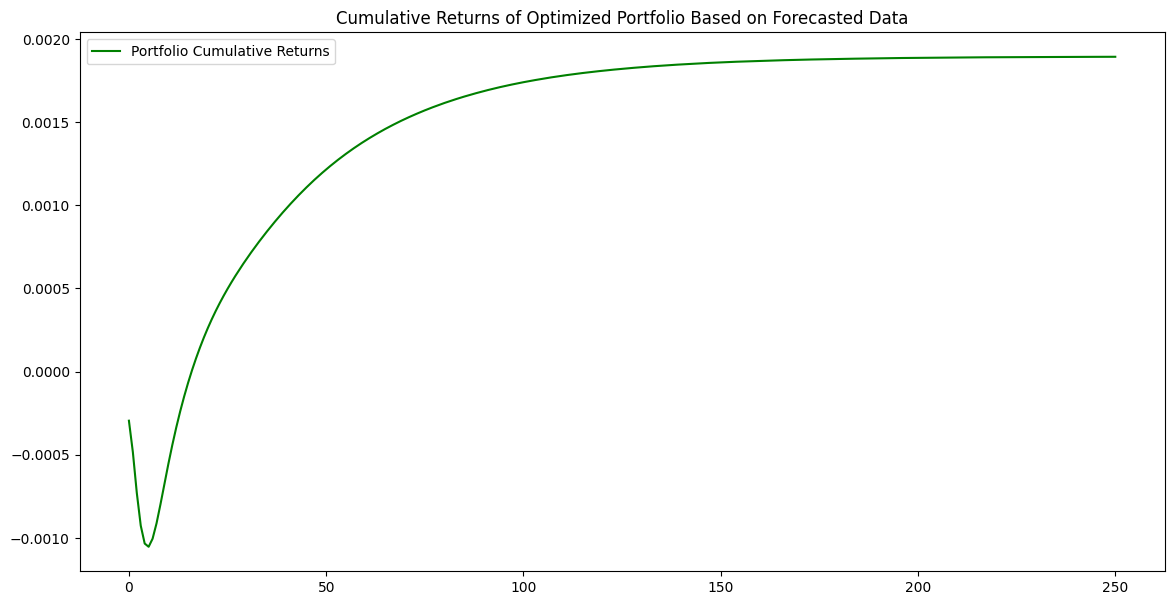

In [21]:
# Visualization of Portfolio Cumulative Returns
portfolio_returns = np.dot(daily_returns, optimal_weights)  # Portfolio daily returns based on optimal weights
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label="Portfolio Cumulative Returns", color='green')
plt.title('Cumulative Returns of Optimized Portfolio Based on Forecasted Data')
plt.legend()
plt.show()

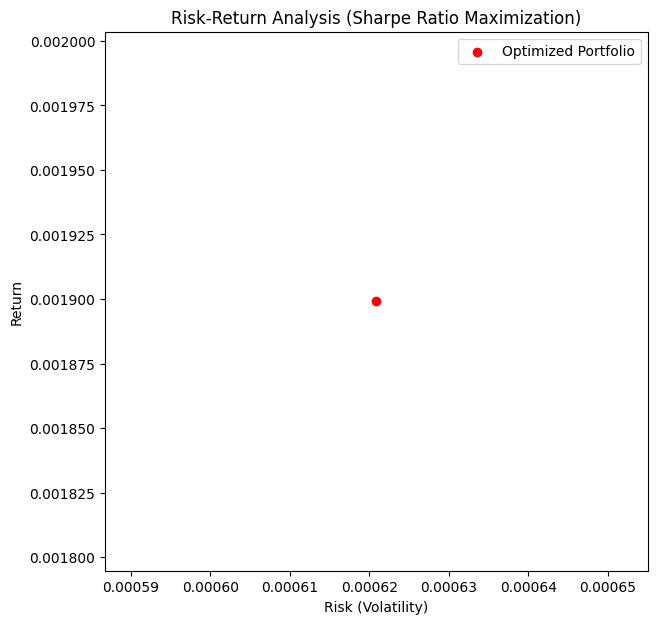

In [22]:
# Risk-Return Analysis Visualization
portfolio_risk_return = pd.DataFrame({
    'Return': [optimal_return],
    'Risk': [optimal_volatility]
})

plt.figure(figsize=(7, 7))
plt.scatter(optimal_volatility, optimal_return, color='red', label="Optimized Portfolio")
plt.title('Risk-Return Analysis (Sharpe Ratio Maximization)')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Return')
plt.legend()
plt.show()